# Spatio-Temporal Traffic Forecasting with Neural Graph Cellular Automata
Petrônio C.  L. Silva  <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0002-1202-2552" href="https://orcid.org/0000-0002-1202-2552" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>, Omid Orang  <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0002-4077-3775" href="https://orcid.org/0000-0002-4077-3775" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>, Lucas Astore, Frederico G. Guimarães <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0001-9238-8839" href="https://orcid.org/0000-0001-9238-8839" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>

In case you have any questions, do not hesitate in contact us using the following e-mail: petronio.candido@ifnmg.edu.br


## Imports

In [1]:
import torch
from torch import nn


from st_nca.common import resume, get_device
from st_nca.datasets.PEMS import PEMS03
from st_nca.cellmodel import CellModel
from st_nca.gca import GraphCellularAutomata, diff_states, timestamp_generator
from st_nca.finetune import FineTunningDataset, finetune_loop

## Data

In [2]:
DEVICE = get_device()
DTYPE = torch.float32
DEFAULT_PATH = 'C:\\Users\\petro\\Dropbox\\Projetos\\futurelab\\posdoc\\st_nca\\st_nca\\st_nca\\'

pems = PEMS03(device = DEVICE, dtype = DTYPE)


c:\Users\petro\Dropbox\Projetos\futurelab\posdoc\st_nca\st_nca\st_nca\embeddings\normalization.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=self.dtype, device=self.device)


In [3]:
from st_nca.finetune import FineTunningDataset, finetune_loop

MODELS_PATH = DEFAULT_PATH + 'weights\\PEMS03\\'

NTRANSF = 4
NHEADS = 16
NTRANSFF = 1024
TRANSFACT = nn.GELU()
MLP = 4
MLPD = 1024
MLPACT = nn.GELU()

ITERATIONS = 1

#ds = pems.get_allsensors_dataset(behavior='deterministic')

model = CellModel(num_tokens = pems.max_length, dim_token = pems.token_dim,
               num_transformers = NTRANSF, num_heads = NHEADS, feed_forward = NTRANSFF, 
               transformer_activation = TRANSFACT,
               mlp = MLP, mlp_dim = MLPD, mlp_activation = MLPACT,
               device = DEVICE, dtype = DTYPE)

file = MODELS_PATH + 'cell_model_{}_{}_{}_{}_{}.h5'.format(NTRANSF,NHEADS,NTRANSFF,MLP,MLPD)

#resume(cm, )

#resume(model, MODELS_PATH + 'UlGfLpFGDbWjtwcWVn59C_weights.h5')

model.load_state_dict(torch.load(file, 
                                 weights_only=True,
                                 map_location=torch.device(get_device())), strict=False)


gca = GraphCellularAutomata(device=DEVICE, dtype=DTYPE, graph = pems.G,
                            max_length = pems.max_length, token_size=pems.token_dim,
                            tokenizer=pems.tokenizer, cell_model = model)

finetune_ds = FineTunningDataset(pems, increment_type='minutes', increment=5, 
                                 steps_ahead=ITERATIONS, step=250)

#X,_ = finetune_ds[0]
#y,_ = finetune_ds[1]

#p = gca.run_dict(X, ITERATIONS,increment_type='minute', increment=5)

#diff_states(y, p[0])

## Fine Tunning

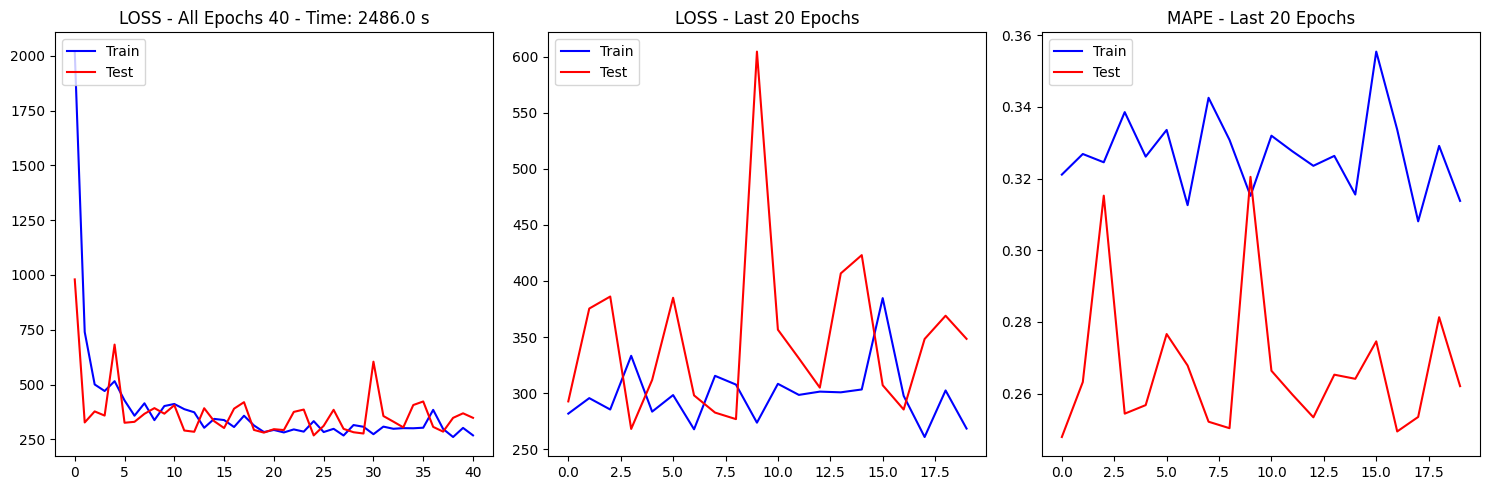

KeyboardInterrupt: 

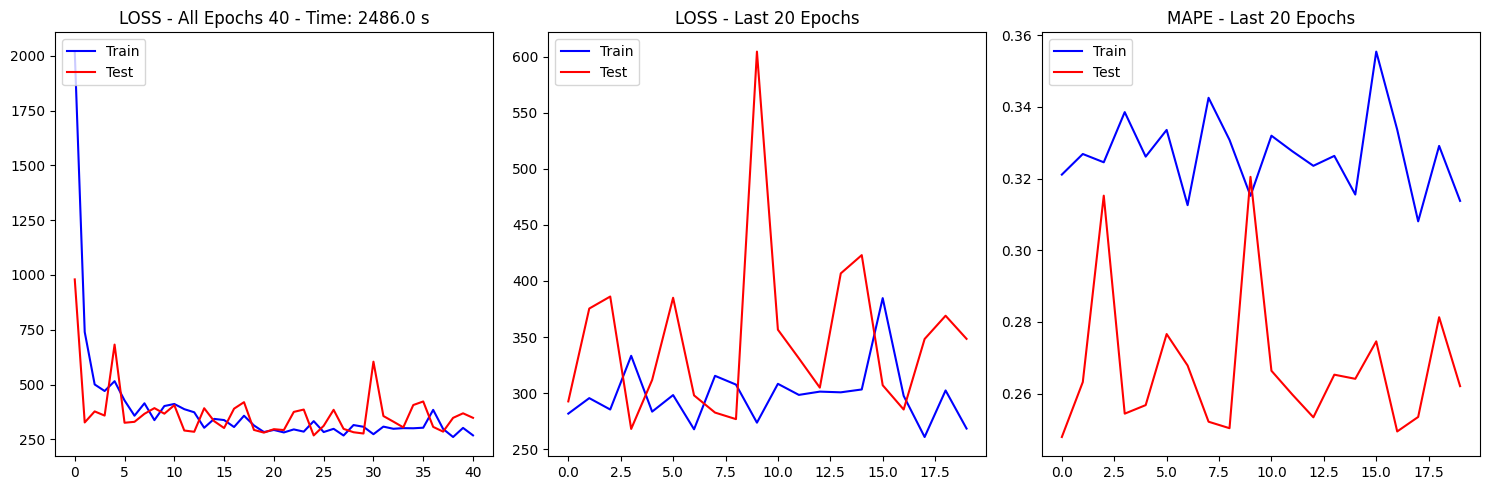

In [4]:
finetune_loop(DEVICE, finetune_ds, gca, 
              iterations = ITERATIONS, increment_type='minutes', increment=5,
              epochs = 200, batch = 1, lr = 0.0001,
              checkpoint_file =  MODELS_PATH + 'gca_{}_{}_{}_{}_{}.pt'.format(NTRANSF,NHEADS,NTRANSFF,MLP,MLPD))